In [ ]:
import gc
import os
import torch
import random
import threading
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn.functional as Fun
from torch.utils.data import Dataset , DataLoader
from torchvision import models, datasets, transforms

In [ ]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
preprocess = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                 ])

In [ ]:
class Flickr(Dataset):

  def __init__(self, img_path, txt_path, transform = None):
    self.sent_len = 0
    self.img_lst = []
    self.cap_lst = []
    self.img_path = img_path
    self.txt_path = txt_path
    self.transform = transform
    self.text = pd.read_csv(txt_path)
    self.imag_lst = self.text['image']
    self.capt_lst = self.text['caption']
    for i in range(0, 40455, 5):
      self.img_lst.append(self.imag_lst[i])
      self.cap_lst.append(self.capt_lst[i])
    self.img_lst = pd.Series(self.img_lst)
    self.cap_lst = pd.Series(self.cap_lst)

    for i in range(len(self.cap_lst)):
      self.cap_lst[i] = ' <SOS> ' + self.cap_lst[i] + ' <EOS> '
      self.cap_lst[i] = self.cap_lst[i].split()
      if len(self.cap_lst[i]) > self.sent_len:
        self.sent_len = len(self.cap_lst[i])
    
    self.vocab = [w for sent in self.cap_lst for w in sent]
    self.vocab = set(self.vocab)
    self.vocab.add('<PAD>')
    self.vocab_size = len(self.vocab)
    self.word_to_index = {w: idx for (idx, w) in enumerate(self.vocab)}
    self.index_to_word = {idx: w for (idx, w) in enumerate(self.vocab)}

    for i in range(len(self.cap_lst)):
      for j in range(len(self.cap_lst[i])):
        self.cap_lst[i][j] = self.word_to_index[self.cap_lst[i][j]]
      for k in range(len(self.cap_lst[i]), self.sent_len):
        self.cap_lst[i].append(self.word_to_index['<PAD>'])
    self.cap_lst = torch.tensor(self.cap_lst)

  def __len__(self):
    return len(self.img_lst)

  def __getitem__(self, index):
    imag_path = os.path.join(self.img_path, self.img_lst[index])
    img = Image.open(imag_path).convert("RGB")
    cap = self.cap_lst[index]
    if self.transform:
      img = self.transform(img)
    return (img,cap)

In [ ]:
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 4}

In [ ]:
dataset = Flickr('/content/drive/MyDrive/Flickr/Images', '/content/drive/MyDrive/Flickr/Captions.txt', preprocess)
data = DataLoader(dataset, **params)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class EncoderCNN(nn.Module):
  def __init__(self, embedding_dim):
    super(EncoderCNN, self).__init__()
    self.encoder_cnn = models.resnet18(weights='DEFAULT')
    self.encoder_cnn.fc = nn.Linear(512, embedding_dim)

  def forward(self, images):
    features = self.encoder_cnn(images)
    return features

class DecoderRNN(nn.Module):
  def __init__(self,  embedding_dim, hidden_size, vocab_size, num_layers):
    super(DecoderRNN, self).__init__()
    self.embedd = nn.Embedding(vocab_size, embedding_dim)
    self.decoder_rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first = True)
    self.linear = nn.Linear(hidden_size, vocab_size)

  def forward(self, features, captions):
    embeddings = self.embedd(captions)
    out, h_n = self.decoder_rnn(embeddings, features.unsqueeze(0))
    out = self.linear(out)
    return out, h_n

class CNNtoRNN(nn.Module):
  def __init__(self, embedding_dim, hidden_size, vocab_size, num_layers):
    super(CNNtoRNN, self).__init__()
    self.Encoder = EncoderCNN(embedding_dim)
    self.Decoder = DecoderRNN(embedding_dim, hidden_size, vocab_size, num_layers)

  def forward(self, images, captions):
    features = self.Encoder(images)
    out, h_n = self.Decoder(features, captions)
    return out, h_n

In [ ]:
embedding_dim = 256
hidden_size = 256
vocab_size = dataset.vocab_size
num_layers = 1

In [ ]:
Model = CNNtoRNN(embedding_dim, hidden_size, vocab_size, num_layers)
Model = Model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.word_to_index["<PAD>"])
optimizer = torch.optim.Adam(Model.parameters(), lr=5e-4,betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
for name, param in Model.Encoder.encoder_cnn.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

In [ ]:
sentence = []
loss_func = []
perplexity = []
for z in range(1,10):
  for t, (images, captions) in enumerate(data):
    images = images.to(device)
    captions = captions.to(device)
    word, h_n = Model(images, captions)
    loss = criterion(word.reshape(-1, word.shape[2]), captions.reshape(-1))
    word = torch.argmax(word, dim = 2)
    loss_func.append(float(loss))
    perplexity.append(float(torch.exp(loss)))
    #for i in range(word.size(0)):
    #  print(sentence)
    #  sentence = []
    #  for j in range(word.size(1)):
    #    sentence.append(dataset.index_to_word[int(word[i][j])])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

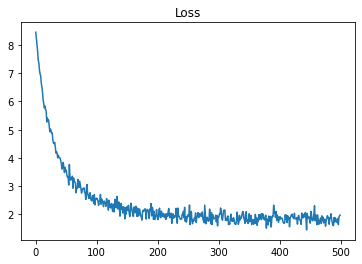

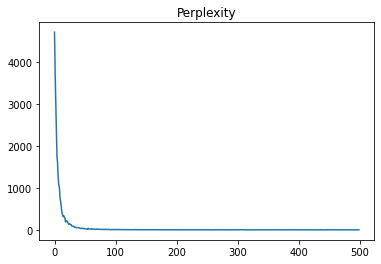

In [ ]:
plt.plot(loss_func[0:500])
plt.title("Loss")
plt.show()
plt.plot(perplexity[0:500])
plt.title("Perplexity")
plt.show()

In [ ]:
print(perplexity[500])

6.358051300048828


['<SOS>', 'a', 'brown', 'and', 'white', 'dog', 'with', 'a', 'ball', 'on', 'some', 'grass', '.', '<EOS>', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']


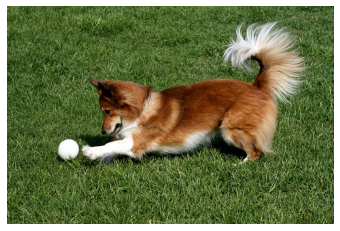

In [ ]:
n = random.randint(0,8090)
path = os.path.join('/content/drive/MyDrive/Flickr/Images', dataset.img_lst[n])
imag = Image.open(path).convert("RGB")
plt.imshow(imag)
plt.axis('off')
sentence = []
imag = preprocess(imag)
capt = dataset.cap_lst[n]
imag = imag.to(device)
capt = capt.to(device)
output , hN = Model(imag.unsqueeze(0), capt.unsqueeze(0))
output = torch.argmax(output, dim = 2)
for i in range(output.size(0)):
  for j in range(output.size(1)):
    sentence.append(dataset.index_to_word[int(output[i][j])])
print(sentence)